## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u(x) (outputs)


We have to find out u(x) for all x in range [-10,10] 

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict

In [2]:
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [4]:
# the deep neural network
class Net(torch.nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)

GPU: True


In [6]:
def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [7]:
## residual as loss function. 
def f(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x) # the dependent variable u is given by the network based on independent variables x
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] 
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$

In [8]:
def exact_U(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [9]:
class Model:
    def __init__(self, net, iterations, x_bc, u_bc, x_test, x_test_exact, model_type):
        
        #adaptive weights: eps_bc (boundary conditions) and eps_f (residual)
        self.eps_bc = None
        self.eps_f = None
        self.eps_collect = []
        
        # residual function 
#         self.f = f        
        
        # boundaries
        self.x_bc = x_bc  
        self.u_bc = u_bc
        
        # validation set
        self.x_test = x_test
        self.x_test_exact = x_test_exact
        
        # training set
        self.x_col = None
        
        self.net = net
        self.iterations = iterations
        self.model_type = model_type
        
        self.Step = []
        self.T_error = []
        self.T_BC = []
        self.T_PDE = []
        self.V_error = []
        
        self.iter=0
        
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
    
    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)
    
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        if not x.requires_grad:
            x = Variable(x, requires_grad=True)
        u = self.train_U(x)        

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        return u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        bc_pred = self.train_U(self.x_bc)
        f_pred = self.net_f(self.x_col)
        loss_bc = torch.mean((bc_pred - self.u_bc) ** 2)
        loss_pde = torch.mean(f_pred ** 2)
        self.T_BC.append(loss_bc.item())
        self.T_PDE.append(loss_pde.item())
        loss = loss_bc + loss_pde

        loss.backward()
        self.iter += 1
        self.Step.append(self.iter)
        self.T_error.append(loss.item())
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_BC: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_bc.item(), loss_pde.item())
            )
        return loss
    def epoch_loss(self):
        loss_pde = torch.mean(self.f(self.x_col, self.train_U) ** 2) #MSE
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)
        self.T_PDE.append(loss_pde.item())
        self.T_BC.append(loss_bc.item())
        return loss_pde, loss_bc

    def likelihood_loss(self, loss_pde, loss_bc):
        loss =  torch.reciprocal(2. * self.eps_f ** 2) * loss_pde.detach() \
              + torch.reciprocal(2. * self.eps_bc ** 2) * loss_bc.detach() \
              + torch.log(self.eps_f * self.eps_bc)
        return loss

    def updated_loss(self, loss_pde, loss_bc):
        loss = torch.reciprocal(2. * self.eps_f.detach() ** 2) * loss_pde  \
             + torch.reciprocal(2. * self.eps_bc.detach() ** 2) * loss_bc \
             + torch.log(self.eps_f.detach() * self.eps_bc.detach())
        return loss
    
    def evaluate(self):
        pred = self.train_U(self.x_test).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def run_PINN(self):      
        pbar = trange(self.iterations, ncols=100)
        for i in pbar:            
            self.optimizer.step(self.loss_func)
            l2_loss = self.evaluate()
            self.V_error.append(l2_loss.item())
#             pbar.set_postfix({'Iter': i,
#                             'Loss': '{0:.2e}'.format(loss.item())
#                                    })
#             with torch.autograd.no_grad():
#                 self.T_error.append(loss.item())
#                 l2_loss = self.evaluate()
#                 self.V_error.append(l2_loss.item())
#                 self.Step.append(i)

                
    def run_lbPINN(self):
        self.eps_f = nn.Parameter(self.eps_f, requires_grad=True)
        self.eps_bc = nn.Parameter(self.eps_bc, requires_grad=True)

        optimizer_weight = torch.optim.Adam([self.eps_f] + [self.eps_bc],lr=1e-3)
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
        pbar = trange(self.iterations, ncols=100)

        for i in pbar:
            self.eps_collect.append([self.eps_f.item(), self.eps_bc.item()])
            loss_pde, loss_bc = self.epoch_loss() 
            loss = self.likelihood_loss(loss_pde,loss_bc)
            
            optimizer_weight.zero_grad()
            loss.backward() 
            optimizer_weight.step()
            
            loss = self.updated_loss(loss_pde,loss_bc)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss = loss_pde + loss_bc
            pbar.set_postfix({'Iter': i,
                            'Loss': '{0:.2e}'.format(loss.item()),
                            'PDE': '{0:.2e}'.format(loss_pde.item()),
                            'BC': '{0:.2e}'.format(loss_bc.item())
                                  })
            
            with torch.autograd.no_grad():
                self.T_error.append(loss.item())
                l2_loss = self.evaluate()
                self.V_error.append(l2_loss.item())
                self.Step.append(i)
        
    def train(self):
        self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
        self.x_col = is_cuda(torch.from_numpy(self.x_col).float())
        start_time = time.time()
        if self.model_type == 0:
            self.run_PINN()

        elif self.model_type == 1:
            self.eps_f = is_cuda(torch.tensor(.02).float())
            self.eps_bc = is_cuda(torch.tensor(2.).float())
            self.run_lbPINN()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [10]:
def draw_exact(model):
    x=np.arange(-10,10,0.02).reshape((1000,1)) 
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_u = model.predict_U(pt_x)
    plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
    plt.plot(x,exact_U(x), label='exact')
    plt.show()

In [11]:
def draw_Terror(model):
    ### Plotting the training error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Training Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_error)
    plt.xlabel(r'iterations',fontsize=15)
    plt.ylabel(r'$MSE_{PDE}+MSE_{BC}$',fontsize=15)
    plt.show()

In [12]:
def draw_Verror(model):
    ### Plotting the validation error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Validation Error plot",fontsize=15) 
    plt.semilogy( model.V_error)
    plt.xlabel('iterations',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)
    plt.show()

In [13]:
def draw_epoch_loss(model):
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.semilogy(model.T_PDE,'b',label=r'$Loss_{PDE}$')
    plt.semilogy(model.T_BC,'r',label=r'$Loss_{BC}$')
    plt.xlabel(r'iterations',fontsize=15)
    plt.ylabel(r'Loss',fontsize=15)
    plt.legend()
    plt.show()

In [14]:
def draw_epoch_e(model):
    eps_collect = np.array(model.eps_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), eps_collect[:, 0], 'b-', label=r'$\epsilon_f$')
    plt.plot(np.array(model.Step), eps_collect[:, 1], 'r-', label=r'$\epsilon_{bc}$')
    plt.xlabel('$Iterations$')
    plt.ylabel('$\epsilon$')
    plt.legend()
    plt.show()

In [15]:
def draw_epoch_w(model):
    eps_collect = np.array(model.eps_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), np.reciprocal(2*eps_collect[:, 0]**2), 'b-', label=r'$\omega_f$')
    plt.plot(np.array(model.Step), np.reciprocal(2*eps_collect[:, 1]**2), 'r-', label=r'$\omega_{bc}$')
    plt.xlabel('$Iterations$')
    plt.ylabel('$\omega$')
    plt.legend()
    plt.show()

In [16]:
x_bc = np.array([[-10],[10]])
u_bc = exact_U(x_bc)
x_bc=is_cuda(torch.from_numpy(x_bc).float())
u_bc=is_cuda(torch.from_numpy(u_bc).float())

x_test = np.random.uniform(low=-10.0, high=10.0, size=(100,1))
x_test_exact = exact_U(x_test)
x_test = is_cuda(torch.from_numpy(x_test).float())
x_test_exact = is_cuda(torch.from_numpy(x_test_exact).float())

layers = [1, 50, 50, 50, 1]
iterations = 5000

In [17]:
from prettytable import PrettyTable

In [18]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# PINN

In [19]:
net = Net(layers)
net = net.to(device)

model_type = 0 # 0:PINN  1:lbPINN
PINN = Model(
    net=net, iterations = iterations,  x_bc=x_bc, u_bc=u_bc , x_test=x_test, x_test_exact=x_test_exact, model_type=model_type)

In [20]:
count_parameters(net)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| layers.layer_0.weight |     50     |
|  layers.layer_0.bias  |     50     |
| layers.layer_1.weight |    2500    |
|  layers.layer_1.bias  |     50     |
| layers.layer_2.weight |    2500    |
|  layers.layer_2.bias  |     50     |
| layers.layer_3.weight |     50     |
|  layers.layer_3.bias  |     1      |
+-----------------------+------------+
Total Trainable Params: 5251


5251

In [21]:
PINN.train()

  3%|█▍                                                         | 126/5000 [00:01<00:28, 170.96it/s]

Iter 100, Loss: 1.75563e+00, Loss_BC: 4.45240e-05, Loss_f: 1.75559e+00


  5%|██▋                                                        | 226/5000 [00:01<00:21, 223.40it/s]

Iter 200, Loss: 1.31397e+00, Loss_BC: 4.03736e-03, Loss_f: 1.30994e+00


  7%|███▊                                                       | 326/5000 [00:02<00:19, 238.31it/s]

Iter 300, Loss: 1.06473e+00, Loss_BC: 1.04357e-04, Loss_f: 1.06462e+00


  9%|█████                                                      | 426/5000 [00:02<00:18, 241.86it/s]

Iter 400, Loss: 7.13437e-01, Loss_BC: 6.04973e-05, Loss_f: 7.13376e-01


 11%|██████▏                                                    | 526/5000 [00:02<00:18, 240.93it/s]

Iter 500, Loss: 5.30664e-01, Loss_BC: 5.92814e-05, Loss_f: 5.30604e-01


 13%|███████▍                                                   | 626/5000 [00:03<00:18, 242.32it/s]

Iter 600, Loss: 3.90411e-01, Loss_BC: 8.76051e-05, Loss_f: 3.90324e-01


 15%|████████▌                                                  | 726/5000 [00:03<00:17, 242.90it/s]

Iter 700, Loss: 1.94007e-01, Loss_BC: 2.35755e-04, Loss_f: 1.93771e-01


 17%|█████████▋                                                 | 826/5000 [00:04<00:17, 242.99it/s]

Iter 800, Loss: 1.23766e-01, Loss_BC: 2.90839e-05, Loss_f: 1.23736e-01


 19%|██████████▉                                                | 926/5000 [00:04<00:16, 241.69it/s]

Iter 900, Loss: 9.29759e-02, Loss_BC: 3.45826e-05, Loss_f: 9.29414e-02


 21%|███████████▉                                              | 1026/5000 [00:04<00:16, 241.32it/s]

Iter 1000, Loss: 2.54682e-02, Loss_BC: 9.25988e-06, Loss_f: 2.54590e-02


 23%|█████████████                                             | 1126/5000 [00:05<00:15, 242.31it/s]

Iter 1100, Loss: 6.32643e-03, Loss_BC: 7.22716e-08, Loss_f: 6.32636e-03


 25%|██████████████▏                                           | 1226/5000 [00:05<00:15, 242.61it/s]

Iter 1200, Loss: 3.47542e-03, Loss_BC: 1.18794e-06, Loss_f: 3.47423e-03


 27%|███████████████▍                                          | 1326/5000 [00:06<00:15, 242.26it/s]

Iter 1300, Loss: 2.33958e-03, Loss_BC: 2.33185e-05, Loss_f: 2.31627e-03


 29%|████████████████▌                                         | 1426/5000 [00:06<00:14, 242.66it/s]

Iter 1400, Loss: 1.62515e-03, Loss_BC: 2.23303e-06, Loss_f: 1.62292e-03


 31%|█████████████████▋                                        | 1526/5000 [00:07<00:14, 242.18it/s]

Iter 1500, Loss: 1.23988e-03, Loss_BC: 9.47010e-07, Loss_f: 1.23894e-03


 33%|██████████████████▊                                       | 1626/5000 [00:07<00:13, 241.75it/s]

Iter 1600, Loss: 2.38342e-03, Loss_BC: 1.11256e-03, Loss_f: 1.27086e-03


 35%|████████████████████                                      | 1726/5000 [00:07<00:13, 242.56it/s]

Iter 1700, Loss: 7.99420e-04, Loss_BC: 5.94103e-08, Loss_f: 7.99361e-04


 37%|█████████████████████▏                                    | 1826/5000 [00:08<00:13, 242.24it/s]

Iter 1800, Loss: 6.67562e-04, Loss_BC: 2.54918e-08, Loss_f: 6.67537e-04


 39%|██████████████████████▎                                   | 1926/5000 [00:08<00:12, 241.88it/s]

Iter 1900, Loss: 5.99478e-04, Loss_BC: 1.75909e-05, Loss_f: 5.81887e-04


 41%|███████████████████████▌                                  | 2026/5000 [00:09<00:12, 242.43it/s]

Iter 2000, Loss: 5.00209e-04, Loss_BC: 3.81438e-08, Loss_f: 5.00171e-04


 43%|████████████████████████▋                                 | 2126/5000 [00:09<00:11, 242.42it/s]

Iter 2100, Loss: 1.79247e-03, Loss_BC: 1.01093e-04, Loss_f: 1.69138e-03


 45%|█████████████████████████▊                                | 2226/5000 [00:09<00:11, 242.86it/s]

Iter 2200, Loss: 4.39235e-04, Loss_BC: 4.05142e-05, Loss_f: 3.98721e-04


 47%|██████████████████████████▉                               | 2326/5000 [00:10<00:11, 242.39it/s]

Iter 2300, Loss: 3.42782e-04, Loss_BC: 5.14792e-08, Loss_f: 3.42730e-04


 49%|████████████████████████████▏                             | 2426/5000 [00:10<00:10, 242.81it/s]

Iter 2400, Loss: 3.08546e-04, Loss_BC: 2.92935e-08, Loss_f: 3.08517e-04


 51%|█████████████████████████████▎                            | 2526/5000 [00:11<00:10, 241.30it/s]

Iter 2500, Loss: 5.53089e-04, Loss_BC: 2.03869e-04, Loss_f: 3.49219e-04


 53%|██████████████████████████████▍                           | 2626/5000 [00:11<00:09, 242.35it/s]

Iter 2600, Loss: 2.58815e-04, Loss_BC: 3.02726e-08, Loss_f: 2.58784e-04


 55%|███████████████████████████████▌                          | 2726/5000 [00:11<00:09, 242.53it/s]

Iter 2700, Loss: 2.58270e-04, Loss_BC: 1.41609e-05, Loss_f: 2.44109e-04


 57%|████████████████████████████████▊                         | 2826/5000 [00:12<00:08, 242.97it/s]

Iter 2800, Loss: 2.27128e-04, Loss_BC: 1.07152e-07, Loss_f: 2.27020e-04


 59%|█████████████████████████████████▉                        | 2926/5000 [00:12<00:08, 243.03it/s]

Iter 2900, Loss: 2.24864e-03, Loss_BC: 1.29461e-04, Loss_f: 2.11918e-03


 61%|███████████████████████████████████                       | 3026/5000 [00:13<00:08, 243.05it/s]

Iter 3000, Loss: 2.13698e-04, Loss_BC: 7.17197e-06, Loss_f: 2.06526e-04


 63%|████████████████████████████████████▎                     | 3126/5000 [00:13<00:07, 242.81it/s]

Iter 3100, Loss: 1.95677e-04, Loss_BC: 6.60860e-07, Loss_f: 1.95016e-04


 65%|█████████████████████████████████████▍                    | 3226/5000 [00:14<00:07, 243.05it/s]

Iter 3200, Loss: 3.98419e-04, Loss_BC: 1.51856e-04, Loss_f: 2.46563e-04


 67%|██████████████████████████████████████▌                   | 3326/5000 [00:14<00:06, 243.30it/s]

Iter 3300, Loss: 2.72501e-04, Loss_BC: 1.82749e-05, Loss_f: 2.54226e-04


 69%|███████████████████████████████████████▋                  | 3426/5000 [00:14<00:06, 244.95it/s]

Iter 3400, Loss: 1.11723e-03, Loss_BC: 6.78580e-04, Loss_f: 4.38647e-04


 71%|████████████████████████████████████████▉                 | 3526/5000 [00:15<00:05, 245.87it/s]

Iter 3500, Loss: 1.65452e-04, Loss_BC: 1.63744e-07, Loss_f: 1.65289e-04


 73%|██████████████████████████████████████████                | 3626/5000 [00:15<00:05, 245.64it/s]

Iter 3600, Loss: 1.59809e-04, Loss_BC: 3.40521e-08, Loss_f: 1.59775e-04


 75%|███████████████████████████████████████████▏              | 3726/5000 [00:16<00:05, 243.94it/s]

Iter 3700, Loss: 1.63280e-04, Loss_BC: 7.08090e-06, Loss_f: 1.56199e-04


 77%|████████████████████████████████████████████▍             | 3826/5000 [00:16<00:04, 242.17it/s]

Iter 3800, Loss: 1.61283e-04, Loss_BC: 3.03992e-06, Loss_f: 1.58243e-04


 79%|█████████████████████████████████████████████▌            | 3926/5000 [00:16<00:04, 242.39it/s]

Iter 3900, Loss: 1.49135e-04, Loss_BC: 4.29801e-06, Loss_f: 1.44837e-04


 81%|██████████████████████████████████████████████▋           | 4026/5000 [00:17<00:04, 242.99it/s]

Iter 4000, Loss: 2.05601e-04, Loss_BC: 4.27174e-05, Loss_f: 1.62884e-04


 83%|███████████████████████████████████████████████▊          | 4126/5000 [00:17<00:03, 243.99it/s]

Iter 4100, Loss: 1.39221e-04, Loss_BC: 7.95109e-07, Loss_f: 1.38426e-04


 85%|█████████████████████████████████████████████████         | 4226/5000 [00:18<00:03, 243.91it/s]

Iter 4200, Loss: 1.44980e-04, Loss_BC: 1.04641e-05, Loss_f: 1.34516e-04


 87%|██████████████████████████████████████████████████▏       | 4326/5000 [00:18<00:02, 244.59it/s]

Iter 4300, Loss: 3.65944e-04, Loss_BC: 8.20990e-05, Loss_f: 2.83845e-04


 89%|███████████████████████████████████████████████████▎      | 4426/5000 [00:18<00:02, 245.63it/s]

Iter 4400, Loss: 1.20748e-04, Loss_BC: 2.00094e-08, Loss_f: 1.20728e-04


 91%|████████████████████████████████████████████████████▌     | 4526/5000 [00:19<00:01, 245.72it/s]

Iter 4500, Loss: 1.25103e-04, Loss_BC: 5.62013e-06, Loss_f: 1.19483e-04


 93%|█████████████████████████████████████████████████████▋    | 4626/5000 [00:19<00:01, 245.68it/s]

Iter 4600, Loss: 1.71918e-04, Loss_BC: 8.73931e-06, Loss_f: 1.63179e-04


 95%|██████████████████████████████████████████████████████▊   | 4726/5000 [00:20<00:01, 245.69it/s]

Iter 4700, Loss: 8.81029e-04, Loss_BC: 4.58888e-04, Loss_f: 4.22141e-04


 97%|███████████████████████████████████████████████████████▉  | 4826/5000 [00:20<00:00, 245.51it/s]

Iter 4800, Loss: 1.06757e-04, Loss_BC: 3.67248e-08, Loss_f: 1.06720e-04


 99%|█████████████████████████████████████████████████████████▏| 4926/5000 [00:20<00:00, 245.53it/s]

Iter 4900, Loss: 1.16962e-04, Loss_BC: 2.59195e-06, Loss_f: 1.14370e-04


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 234.96it/s]

Iter 5000, Loss: 1.24291e-04, Loss_BC: 1.55093e-05, Loss_f: 1.08781e-04
Training time: 21.28


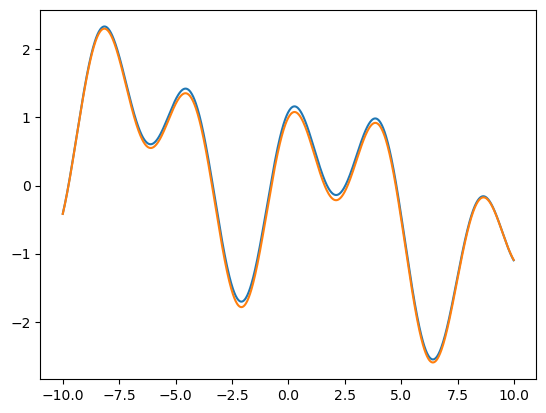

In [22]:
draw_exact(PINN)

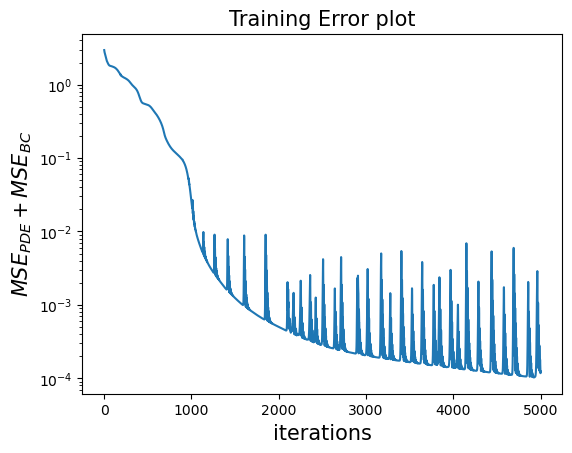

In [23]:
draw_Terror(PINN)    

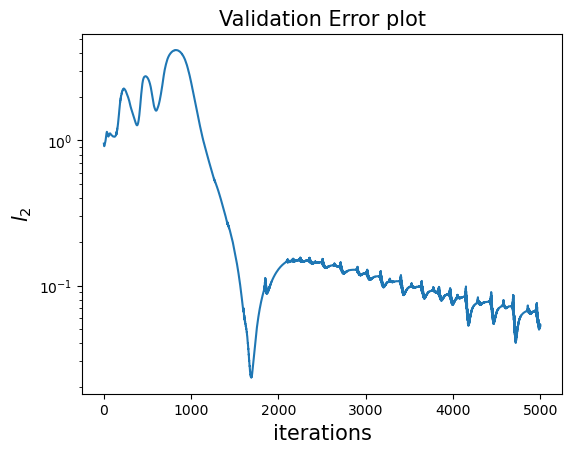

In [24]:
draw_Verror(PINN) 

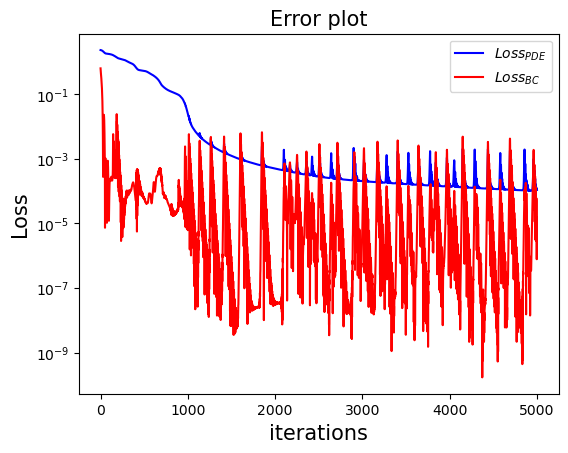

In [25]:
draw_epoch_loss(PINN)

# lbPINN

In [27]:
net = Net(layers)
# net = Net()
net = net.to(device)

model_type = 1 # 0:PINN  1:lbPINN

lbPINN = Model(
    net=net, iterations = iterations, f=f, x_bc=x_bc, u_bc=u_bc , x_test=x_test, x_test_exact=x_test_exact, model_type=model_type)

In [28]:
count_parameters(net)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| layers.layer_0.weight |     50     |
|  layers.layer_0.bias  |     50     |
| layers.layer_1.weight |    2500    |
|  layers.layer_1.bias  |     50     |
| layers.layer_2.weight |    2500    |
|  layers.layer_2.bias  |     50     |
| layers.layer_3.weight |     50     |
|  layers.layer_3.bias  |     1      |
+-----------------------+------------+
Total Trainable Params: 5251


5251

In [29]:
lbPINN.train()

100%|█████| 5000/5000 [00:32<00:00, 151.52it/s, Iter=4999, Loss=5.82e-04, PDE=5.82e-04, BC=2.17e-09]

Training time: 33.00


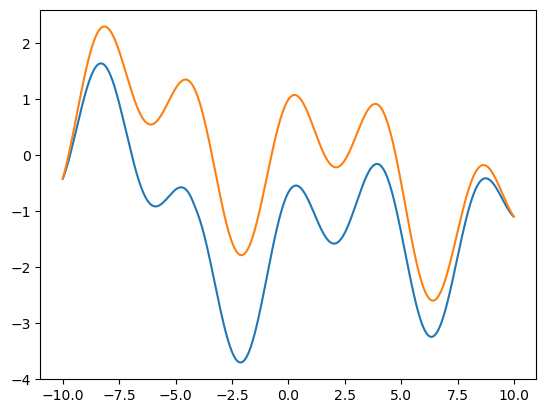

In [30]:
draw_exact(lbPINN)

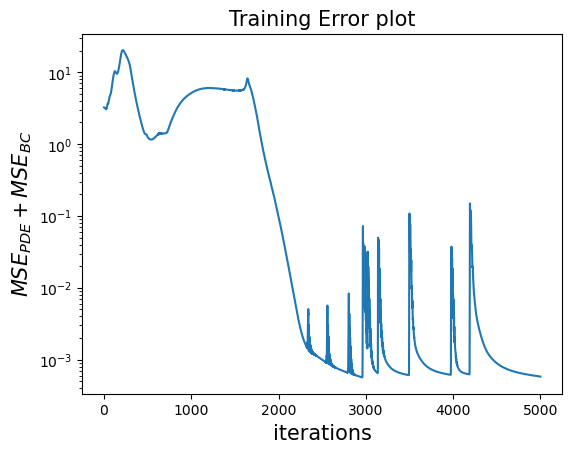

In [31]:
draw_Terror(lbPINN)

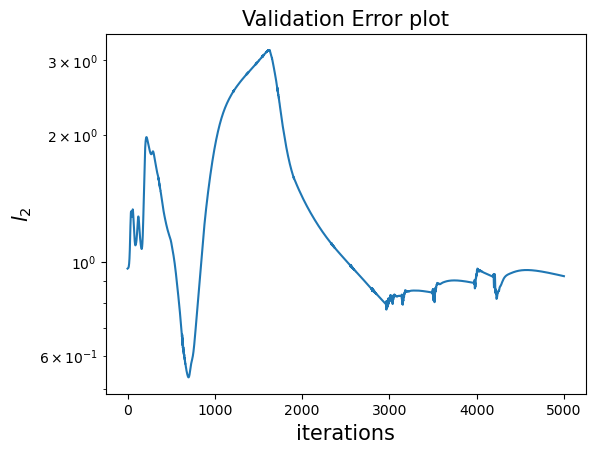

In [32]:
draw_Verror(lbPINN)

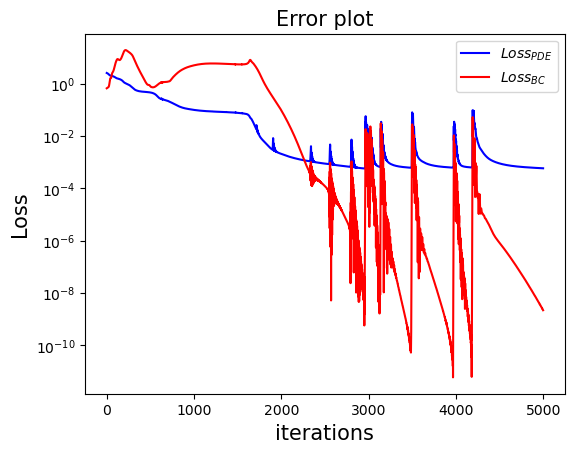

In [33]:
draw_epoch_loss(lbPINN)

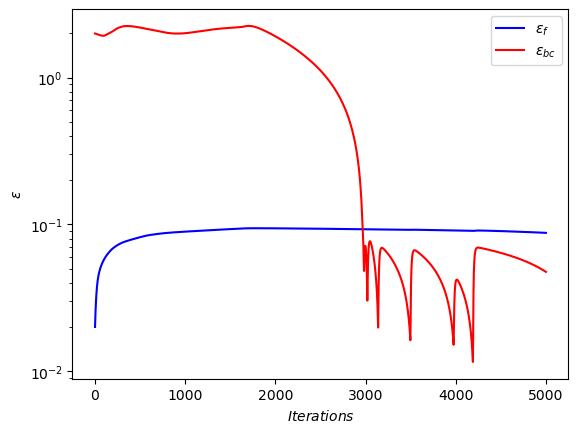

In [34]:
draw_epoch_e(lbPINN)

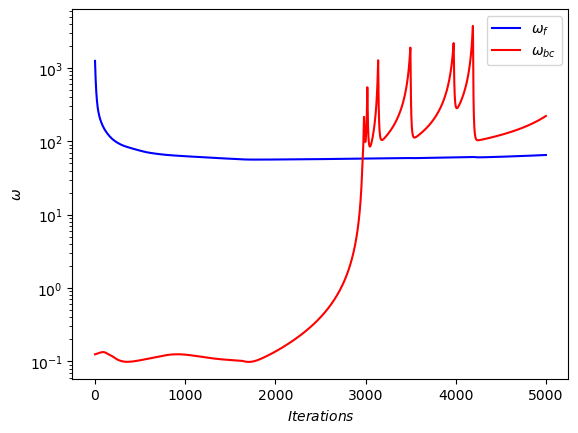

In [35]:
draw_epoch_w(lbPINN)